# Model Development - Binary Classification for Price Direction Prediction

## Models that will be developed

We will build binary classification models to predict whether Bitcoin's price will increase the next day (1) or not (0).

#### Machine Learning Models

- **Logistic Regression**: Baseline linear classifier for interpretability
- **Random Forest Classifier**: Ensemble method robust to overfitting
- **XGBoost Classifier**: Gradient boosting for high performance
- **LightGBM Classifier**: Fast gradient boosting with categorical feature support

#### Deep Learning Models

- **LSTM Classifier**: Sequential model for temporal pattern recognition
- **GRU Classifier**: Efficient variant of LSTM

## Evaluation Metrics

**Primary Metric:**
- **Accuracy** - Percentage of correct predictions
- **Precision** - Of predicted ups, how many were actually ups
- **Recall** - Of actual ups, how many did we catch
- **F1-Score** - Harmonic mean of precision and recall

**Supporting Metrics:**
- **ROC-AUC** - Area under the receiver operating characteristic curve
- **Confusion Matrix** - Detailed breakdown of predictions
- **Classification Report** - Comprehensive metrics summary

## Helper Functions

In `direction_prediction_utils.py` there are helper functions for binary classification:
- `create_binary_target`: Creates binary target (1 if price goes up, 0 otherwise)
- `calculate_classification_metrics`: Computes accuracy, precision, recall, F1, ROC-AUC
- `plot_confusion_matrix`: Visualizes prediction errors
- `plot_roc_curve`: Shows model discrimination ability
- `plot_feature_importance`: Displays most important features

## 0. Import Libraries, Define Constants, Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set global plotting style
sns.set_theme(style="whitegrid")

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
import optuna

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from utils.common_utils import time_series_train_val_test_split

from utils.direction_prediction_utils import (
    create_binary_target,
    calculate_classification_metrics,
    plot_confusion_matrix,
    plot_roc_curve,
    plot_feature_importance,
    plot_top_classification_models,
    evaluate_classifier_feature_set,
    train_nn_classifier,
)

from utils.model_development_classes import SequenceDatasetClassifier

/Users/klipiec/Desktop/Internship/projects/crypto_forecasting_project/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Constants

# Base directories
DATA_DIR = Path("../data/")
FILE_NAME = "bitcoin_data_processed.csv"
DATA_PATH = DATA_DIR / FILE_NAME

# Reproducibility
RANDOM_SEED = 2137
np.random.seed(RANDOM_SEED)

# Results container
CLASSIFICATION_RESULTS = {}

# Data split ratios
TRAIN_SIZE = 0.7
VALIDATION_SIZE = 0.15
TEST_SIZE = 0.15

# Features in the dataset
PRICE_DYNAMICS = [
    "Close",
    "Return",
    "Log_Return",
    "Price_Diff",
    "Low_High_Diff",
    "Open_Close_Diff",
    "Open_Close_Up",
    "SMA_30",
    "Volume",
]

LAG_FEATURES = [
    "Close_Lag1",
    "Close_Lag5",
    "Close_Lag7",
    "Close_Lag30",
    "Return_Lag1",
    "Return_Lag5",
    "Return_Lag7",
    "Return_Lag30",
]

TECH_INDICATORS = ["MACD", "RSI"]

ROLLING_STATS = ["Rolling_Mean_Return_30", "Rolling_Std_Return_30"]

MOMENTUM_FEATURES = ["Close_Change_5d", "Close_Change_10d", "Close_Change_20d"]

TEMPORAL_FEATURES = ["Month_Sin", "Month_Cos", "DayOfWeek_Sin", "DayOfWeek_Cos"]

# All features
ALL_FEATURES = (
    PRICE_DYNAMICS
    + LAG_FEATURES
    + TECH_INDICATORS
    + ROLLING_STATS
    + MOMENTUM_FEATURES
    + TEMPORAL_FEATURES
)

# Baseline features for base models
BASELINE_FEATURES = [
    "Close",
    "Volume",
    "Close_Lag7",
    "Close_Lag30",
    "Return",
    "Return_Lag7",
    "Return_Lag30",
    "Month_Sin",
    "Month_Cos",
    "DayOfWeek_Sin",
    "DayOfWeek_Cos",
]

In [3]:
# Load Data
df = pd.read_csv(DATA_PATH)
df.head()

,Date,Close,High,Low,Open,Return,Log_Return,Price_Diff,Volume,Close_Lag1,...,Close_Change_20d,MACD,RSI,Month,DayOfWeek,Day,Month_Sin,Month_Cos,DayOfWeek_Sin,DayOfWeek_Cos
0,2014-10-18,391.441986,395.157990,378.971008,383.976013,0.020023,0.019825,7.683990,11416800,383.757996,...,0.037809,1.847972,75.469711,10,5,18,-0.866025,0.5,-0.974928,-0.222521
1,2014-10-19,389.545990,393.938995,386.457001,391.253998,-0.004844,-0.004855,-1.895996,5914570,391.441986,...,0.037497,2.414320,79.658722,10,6,19,-0.866025,0.5,-0.781831,0.623490
2,2014-10-20,382.845001,390.084015,378.252014,389.230988,-0.017202,-0.017352,-6.700989,16419000,389.545990,...,-0.010593,2.330291,73.241668,10,0,20,-0.866025,0.5,0.000000,1.000000
3,2014-10-21,386.475006,392.645996,380.834015,382.420990,0.009482,0.009437,3.630005,14188900,382.845001,...,0.007455,2.509406,72.644511,10,1,21,-0.866025,0.5,0.781831,0.623490
4,2014-10-22,383.157990,388.575989,382.248993,386.118011,-0.008583,-0.008620,-3.317017,11641300,386.475006,...,0.021559,2.371179,65.480215,10,2,22,-0.866025,0.5,0.974928,-0.222521


In [4]:
# Convert Date to datetime and set as index
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df.sort_index(inplace=True)

# Drop unnecessary columns
df = df.drop(["Open", "High", "Low"], axis=1)

# Create binary target: 1 if next day price goes up, 0 otherwise
df["Price_Up"] = create_binary_target(df, "Close")

# Drop NaN values created by target
df = df.dropna()

print(f"Dataset shape: {df.shape}")
print(f"\nTarget distribution:")
print(df["Price_Up"].value_counts())
print(f"\nClass balance: {df['Price_Up'].mean():.2%} positive class")

Dataset shape: (4107, 32)

Target distribution:
Price_Up
1    2164
0    1943
Name: count, dtype: int64

Class balance: 52.69% positive class


## 1. Model Development

### 1. Prepare Data

In [5]:
train_df, val_df, test_df = time_series_train_val_test_split(
    df, TRAIN_SIZE, VALIDATION_SIZE
)

print(f"Training set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")

# Separate features and target
X_train = train_df[ALL_FEATURES]
y_train = train_df["Price_Up"]

X_val = val_df[ALL_FEATURES]
y_val = val_df["Price_Up"]

X_test = test_df[ALL_FEATURES]
y_test = test_df["Price_Up"]

print(f"\nTrain class distribution: {y_train.mean():.2%}")
print(f"Val class distribution: {y_val.mean():.2%}")
print(f"Test class distribution: {y_test.mean():.2%}")

Training set: 2874 samples
Validation set: 616 samples
Test set: 617 samples

Train class distribution: 53.76%
Val class distribution: 49.84%
Test class distribution: 50.57%


### 2. Baseline Models

#### 1. Naive Classifier 1 - Always Predict Majority Class

In [6]:
# Baseline 1 - Naive classifier: always predict the majority class from training
majority_class = y_train.mode()[0]
naive_predictions_majority = np.full(len(y_val), majority_class)

naive_majority_metrics = calculate_classification_metrics(
    y_val, naive_predictions_majority
)

print(f"{'=' * 60}")
print("Baseline 1 - Naive Classifier (Always Predict Majority Class)")
print(f"{'=' * 60}")
print(f"Predicted class: {majority_class}")
for metric, value in naive_majority_metrics.items():
    if metric not in ["confusion_matrix", "classification_report"]:
        print(f"  {metric}: {value:.4f}")
# Store results
CLASSIFICATION_RESULTS["Naive_Baseline"] = {
    "val_metrics": naive_majority_metrics,
    "model": None,
    "features": None,
}

Baseline 1 - Naive Classifier (Always Predict Majority Class)
Predicted class: 1
  Accuracy: 0.4984
  Precision: 0.4984
  Recall: 1.0000
  F1_Score: 0.6652


/Users/klipiec/Desktop/Internship/projects/crypto_forecasting_project/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/klipiec/Desktop/Internship/projects/crypto_forecasting_project/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/klipiec/Desktop/Internship/projects/crypto_forecasting_project/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with 

#### 2. Naive Classifier 2 - Random Guessing

In [7]:
# Baseline 2 - Random Classifier (50/50)
np.random.seed(RANDOM_SEED)
naive_predictions_random = np.random.randint(0, 2, size=len(y_val))

naive_random_metrics = calculate_classification_metrics(y_val, naive_predictions_random)

print(f"{'=' * 60}")
print("Baseline - Random Classifier (50/50 chance)")
print(f"{'=' * 60}")
for metric, value in naive_random_metrics.items():
    if metric not in ["confusion_matrix", "classification_report"]:
        print(f"  {metric}: {value:.4f}")

CLASSIFICATION_RESULTS["Naive_Random"] = {
    "val_metrics": naive_random_metrics,
    "model": None,
    "features": None,
}

Baseline - Random Classifier (50/50 chance)
  Accuracy: 0.4886
  Precision: 0.4868
  Recall: 0.4788
  F1_Score: 0.4828


#### 3. Naive Classifier 3 - Momentum Classifier (Follow Previous Direction)

In [8]:
# Baseline 3 - Previous Day Direction (Momentum)
# Predict that tomorrow will move in the same direction as today
# If today's price > yesterday's price, predict up (1), else predict down (0)
val_df_with_prev = val_df.copy()
val_df_with_prev["Prev_Direction"] = (
    val_df_with_prev["Close"] > val_df_with_prev["Close"].shift(1)
).astype(int)

naive_predictions_momentum = val_df_with_prev["Prev_Direction"]

# Remove first value (NaN from shift)
naive_predictions_momentum = naive_predictions_momentum[1:]
y_val_momentum = y_val.iloc[1:]

naive_momentum_metrics = calculate_classification_metrics(
    y_val_momentum, naive_predictions_momentum
)
print(f"{'=' * 60}")
print("Baseline 3 - Momentum Classifier (Follow Previous Direction)")
print(f"{'=' * 60}")

for metric, value in naive_momentum_metrics.items():
    if metric not in ["confusion_matrix", "classification_report"]:
        print(f"  {metric}: {value:.4f}")

CLASSIFICATION_RESULTS["Naive_Momentum"] = {
    "val_metrics": naive_momentum_metrics,
    "model": None,
    "features": None,
}

Baseline 3 - Momentum Classifier (Follow Previous Direction)
  Accuracy: 0.4650
  Precision: 0.4625
  Recall: 0.4641
  F1_Score: 0.4633


#### Comparison of Baseline Models

In [9]:
print("\n" + "=" * 80)
print("Summary: Baseline Comparisons")
print("=" * 80)
print(
    f"{'Baseline':<30} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}"
)
print("-" * 80)
print(
    f"{'Always Majority':<30} {naive_majority_metrics['Accuracy']:<12.4f} {naive_majority_metrics['Precision']:<12.4f} {naive_majority_metrics['Recall']:<12.4f} {naive_majority_metrics['F1_Score']:<12.4f}"
)
print(
    f"{'Random (50/50)':<30} {naive_random_metrics['Accuracy']:<12.4f} {naive_random_metrics['Precision']:<12.4f} {naive_random_metrics['Recall']:<12.4f} {naive_random_metrics['F1_Score']:<12.4f}"
)
print(
    f"{'Momentum (Follow Prev)':<30} {naive_momentum_metrics['Accuracy']:<12.4f} {naive_momentum_metrics['Precision']:<12.4f} {naive_momentum_metrics['Recall']:<12.4f} {naive_momentum_metrics['F1_Score']:<12.4f}"
)
print("=" * 80)


Summary: Baseline Comparisons
Baseline                       Accuracy     Precision    Recall       F1-Score    
--------------------------------------------------------------------------------
Always Majority                0.4984       0.4984       1.0000       0.6652      
Random (50/50)                 0.4886       0.4868       0.4788       0.4828      
Momentum (Follow Prev)         0.4650       0.4625       0.4641       0.4633      


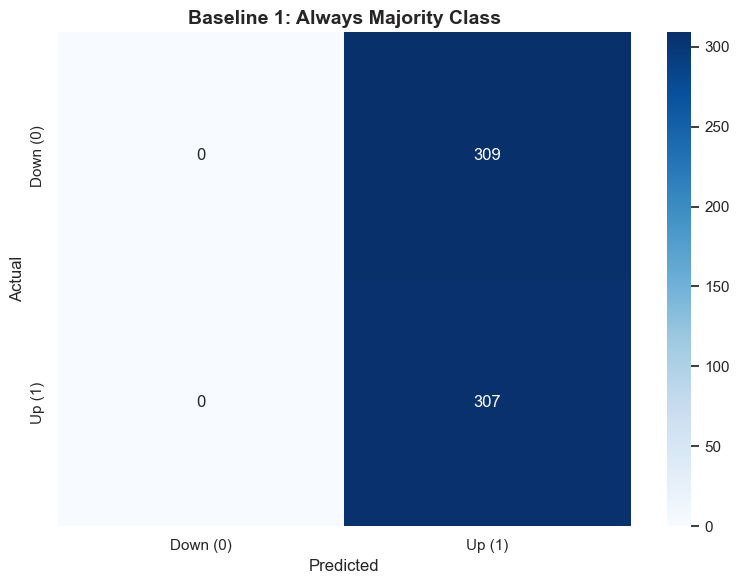

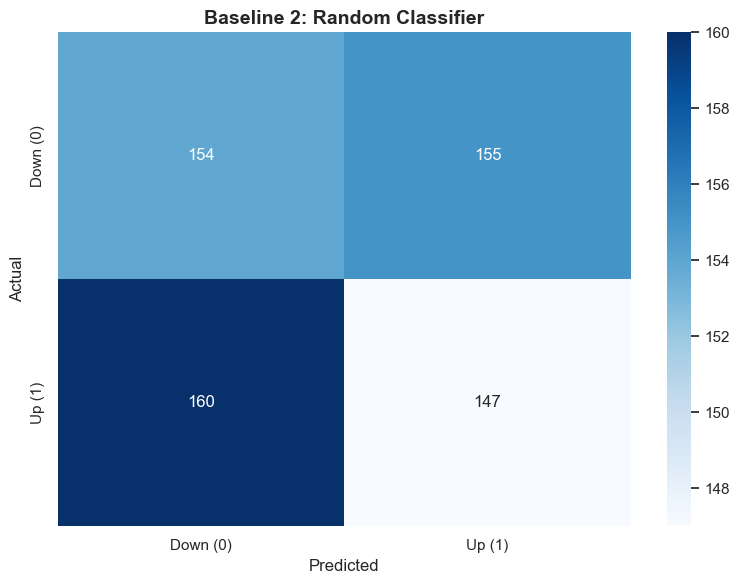

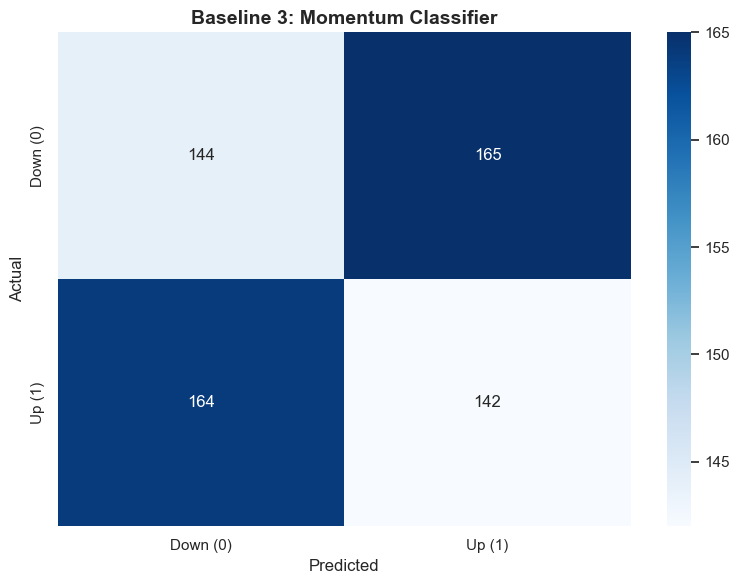

In [10]:
# Visualize baseline performance
plot_confusion_matrix(
    y_val, naive_predictions_majority, title="Baseline 1: Always Majority Class"
)

plot_confusion_matrix(
    y_val, naive_predictions_random, title="Baseline 2: Random Classifier"
)

plot_confusion_matrix(
    y_val_momentum, naive_predictions_momentum, title="Baseline 3: Momentum Classifier"
)

### 3. Machine Learning Models

#### 1. Logistic Regression

In [11]:
# Scale features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[BASELINE_FEATURES])
X_val_scaled = scaler.transform(X_val[BASELINE_FEATURES])

# Train logistic regression
log_reg = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# Predictions
train_pred = log_reg.predict(X_train_scaled)
val_pred = log_reg.predict(X_val_scaled)
val_pred_proba = log_reg.predict_proba(X_val_scaled)[:, 1]

# Evaluate
train_metrics = calculate_classification_metrics(y_train, train_pred)
val_metrics = calculate_classification_metrics(y_val, val_pred, val_pred_proba)

print(f"{'=' * 60}")
print("Logistic Regression Classifier")
print(f"{'=' * 60}")
print("Training Metrics:")
for metric, value in train_metrics.items():
    if metric not in ["confusion_matrix", "classification_report"]:
        print(f"  {metric}: {value:.4f}")

print(f"\n{'=' * 60}")
print("Validation Metrics:")
for metric, value in val_metrics.items():
    if metric not in ["confusion_matrix", "classification_report"]:
        print(f"  {metric}: {value:.4f}")

CLASSIFICATION_RESULTS["Logistic_Regression"] = {
    "train_metrics": train_metrics,
    "val_metrics": val_metrics,
    "model": log_reg,
    "scaler": scaler,
    "features": BASELINE_FEATURES,
}

Logistic Regression Classifier
Training Metrics:
  Accuracy: 0.5487
  Precision: 0.5517
  Recall: 0.8563
  F1_Score: 0.6711

Validation Metrics:
  Accuracy: 0.5049
  Precision: 0.5024
  Recall: 0.6808
  F1_Score: 0.5781
  ROC_AUC: 0.5263


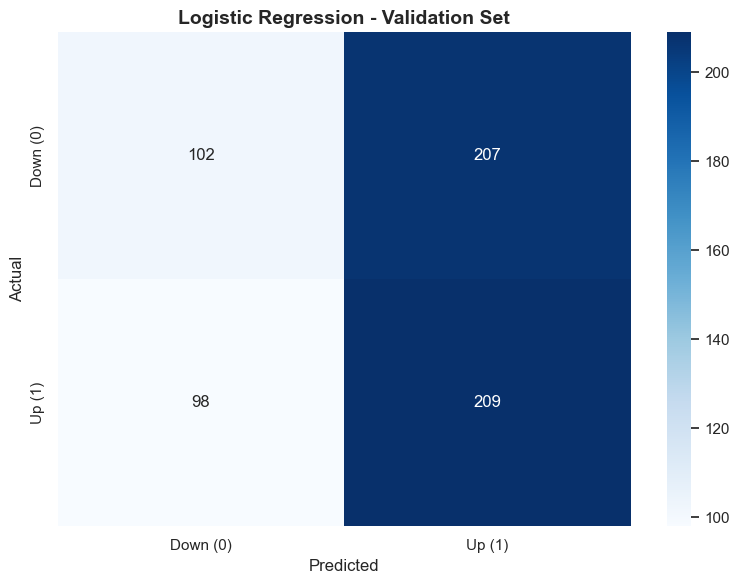

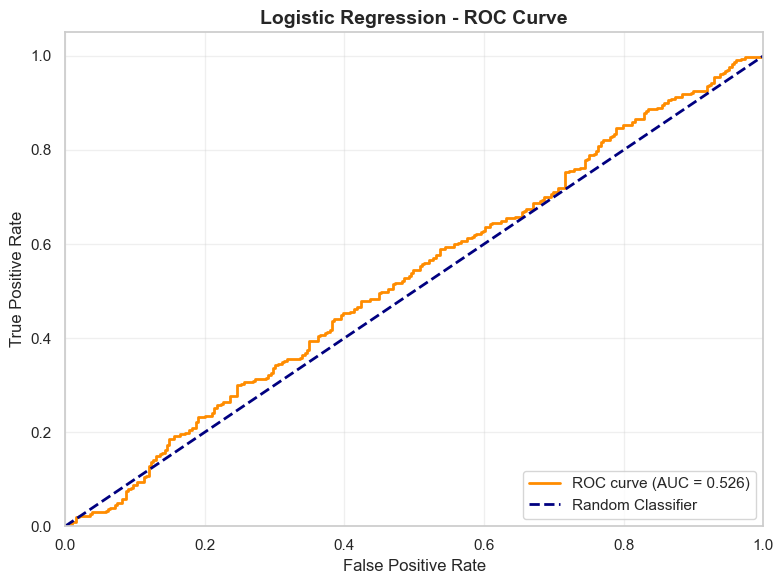

In [12]:
plot_confusion_matrix(y_val, val_pred, title="Logistic Regression - Validation Set")

plot_roc_curve(y_val, val_pred_proba, title="Logistic Regression - ROC Curve")

#### 2. Random Forest Classifier

In [13]:
# Train Random Forest
rf_clf = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)
rf_clf.fit(X_train[BASELINE_FEATURES], y_train)

# Predictions
train_pred = rf_clf.predict(X_train[BASELINE_FEATURES])
val_pred = rf_clf.predict(X_val[BASELINE_FEATURES])
val_pred_proba = rf_clf.predict_proba(X_val[BASELINE_FEATURES])[:, 1]

# Evaluate
train_metrics = calculate_classification_metrics(y_train, train_pred)
val_metrics = calculate_classification_metrics(y_val, val_pred, val_pred_proba)

print(f"{'=' * 60}")
print("Random Forest Classifier")
print(f"{'=' * 60}")
print("Training Metrics:")
for metric, value in train_metrics.items():
    if metric not in ["confusion_matrix", "classification_report"]:
        print(f"  {metric}: {value:.4f}")

print(f"\n{'=' * 60}")
print("Validation Metrics:")
for metric, value in val_metrics.items():
    if metric not in ["confusion_matrix", "classification_report"]:
        print(f"  {metric}: {value:.4f}")

CLASSIFICATION_RESULTS["Random_Forest"] = {
    "train_metrics": train_metrics,
    "val_metrics": val_metrics,
    "model": rf_clf,
    "features": BASELINE_FEATURES,
}

Random Forest Classifier
Training Metrics:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1_Score: 1.0000

Validation Metrics:
  Accuracy: 0.4919
  Precision: 0.4894
  Recall: 0.4495
  F1_Score: 0.4686
  ROC_AUC: 0.4891


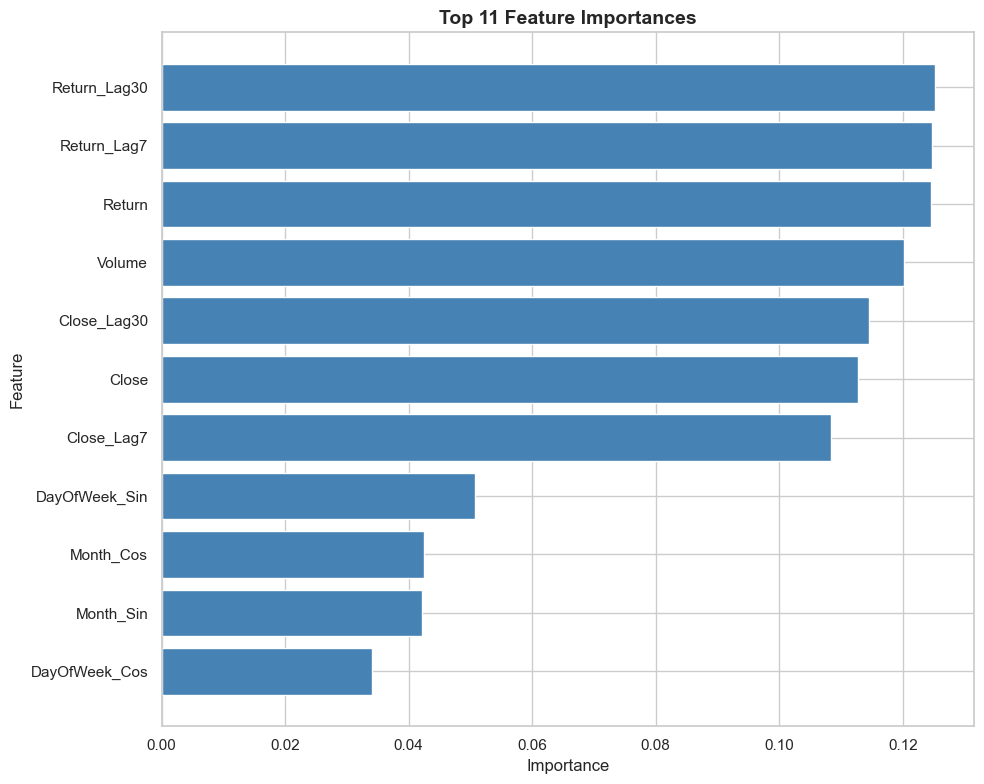

In [14]:
# Plot feature importance
plot_feature_importance(rf_clf, BASELINE_FEATURES, top_n=11)

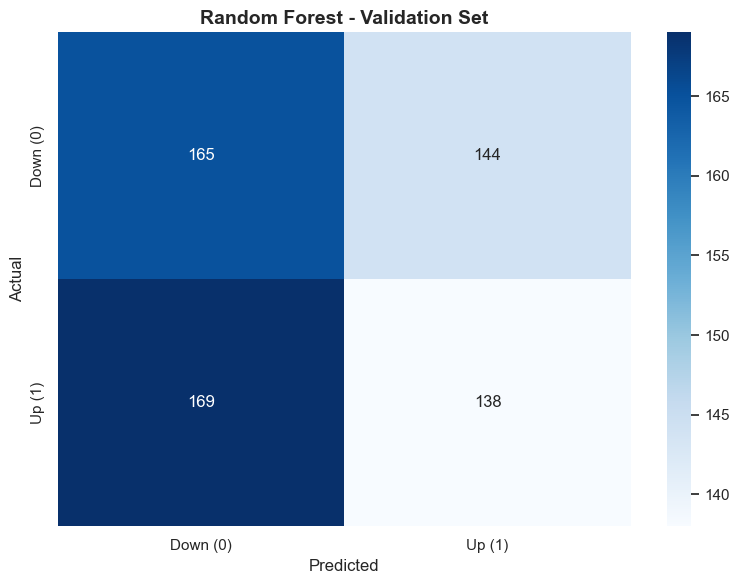

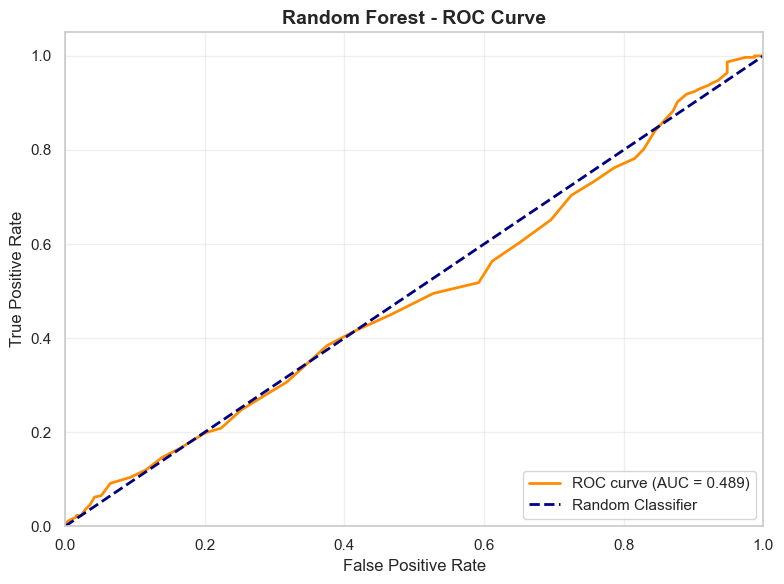

In [15]:
# Visualize confusion matrix and ROC curve
plot_confusion_matrix(y_val, val_pred, title="Random Forest - Validation Set")
plot_roc_curve(y_val, val_pred_proba, title="Random Forest - ROC Curve")

#### 3.XGBoost Classifier

In [16]:
# Train XGBoost
xgb_clf = xgb.XGBClassifier(
    random_state=RANDOM_SEED,
)
xgb_clf.fit(X_train[BASELINE_FEATURES], y_train)

# Predictions
train_pred = xgb_clf.predict(X_train[BASELINE_FEATURES])
val_pred = xgb_clf.predict(X_val[BASELINE_FEATURES])
val_pred_proba = xgb_clf.predict_proba(X_val[BASELINE_FEATURES])[:, 1]

# Evaluate
train_metrics = calculate_classification_metrics(y_train, train_pred)
val_metrics = calculate_classification_metrics(y_val, val_pred, val_pred_proba)

print(f"{'=' * 60}")
print("XGBoost Classifier")
print(f"{'=' * 60}")
print("Training Metrics:")
for metric, value in train_metrics.items():
    if metric not in ["confusion_matrix", "classification_report"]:
        print(f"  {metric}: {value:.4f}")

print(f"\n{'=' * 60}")
print("Validation Metrics:")
for metric, value in val_metrics.items():
    if metric not in ["confusion_matrix", "classification_report"]:
        print(f"  {metric}: {value:.4f}")

CLASSIFICATION_RESULTS["XGBoost"] = {
    "train_metrics": train_metrics,
    "val_metrics": val_metrics,
    "model": xgb_clf,
    "features": BASELINE_FEATURES,
}

XGBoost Classifier
Training Metrics:
  Accuracy: 0.9903
  Precision: 0.9865
  Recall: 0.9955
  F1_Score: 0.9910

Validation Metrics:
  Accuracy: 0.5114
  Precision: 0.5127
  Recall: 0.3941
  F1_Score: 0.4457
  ROC_AUC: 0.4945


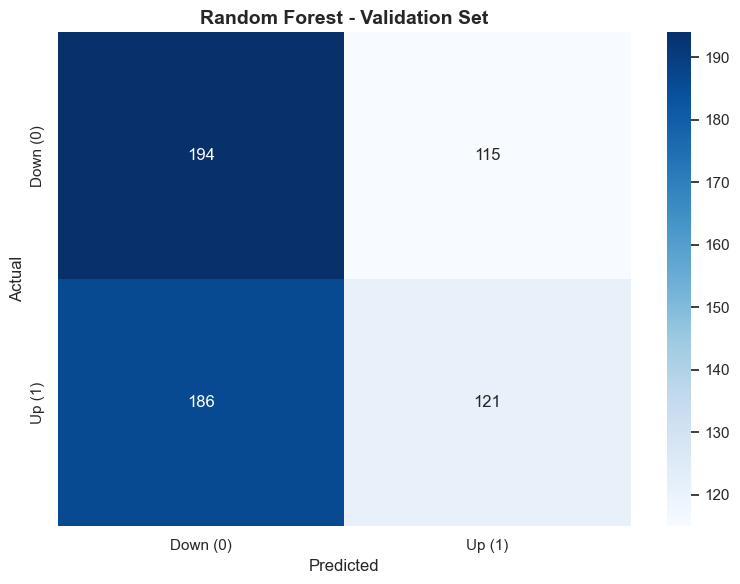

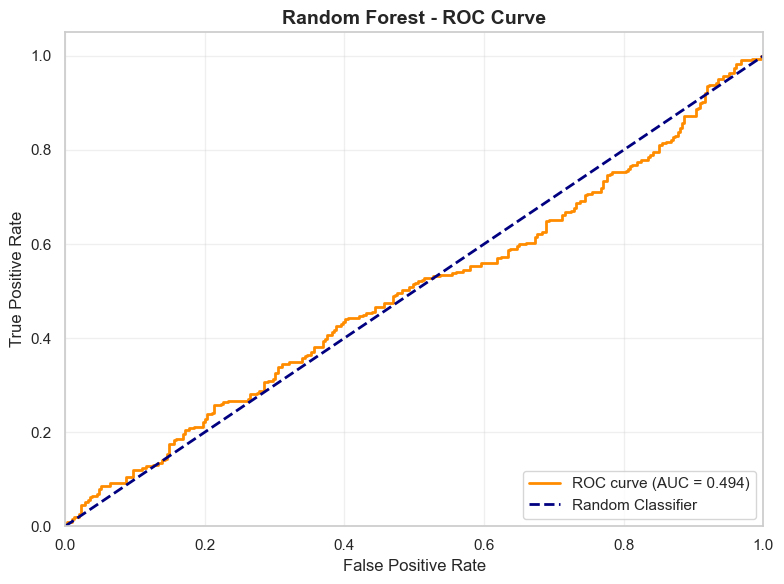

In [17]:
# Visualize confusion matrix and ROC curve
plot_confusion_matrix(y_val, val_pred, title="Random Forest - Validation Set")
plot_roc_curve(y_val, val_pred_proba, title="Random Forest - ROC Curve")

#### 4. LightGBM Classifier

In [18]:
# Train LightGBM
lgb_clf = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=RANDOM_SEED,
    verbose=-1,
)
lgb_clf.fit(X_train[BASELINE_FEATURES], y_train)

# Predictions
train_pred = lgb_clf.predict(X_train[BASELINE_FEATURES])
val_pred = lgb_clf.predict(X_val[BASELINE_FEATURES])
val_pred_proba = lgb_clf.predict_proba(X_val[BASELINE_FEATURES])[:, 1]

# Evaluate
train_metrics = calculate_classification_metrics(y_train, train_pred)
val_metrics = calculate_classification_metrics(y_val, val_pred, val_pred_proba)

print(f"{'=' * 60}")
print("LightGBM Classifier")
print(f"{'=' * 60}")
print("Training Metrics:")
for metric, value in train_metrics.items():
    if metric not in ["confusion_matrix", "classification_report"]:
        print(f"  {metric}: {value:.4f}")

print(f"\n{'=' * 60}")
print("Validation Metrics:")
for metric, value in val_metrics.items():
    if metric not in ["confusion_matrix", "classification_report"]:
        print(f"  {metric}: {value:.4f}")

CLASSIFICATION_RESULTS["LightGBM"] = {
    "train_metrics": train_metrics,
    "val_metrics": val_metrics,
    "model": lgb_clf,
    "features": BASELINE_FEATURES,
}

LightGBM Classifier
Training Metrics:
  Accuracy: 0.8629
  Precision: 0.8371
  Recall: 0.9249
  F1_Score: 0.8788

Validation Metrics:
  Accuracy: 0.5081
  Precision: 0.5076
  Recall: 0.4365
  F1_Score: 0.4694
  ROC_AUC: 0.5065


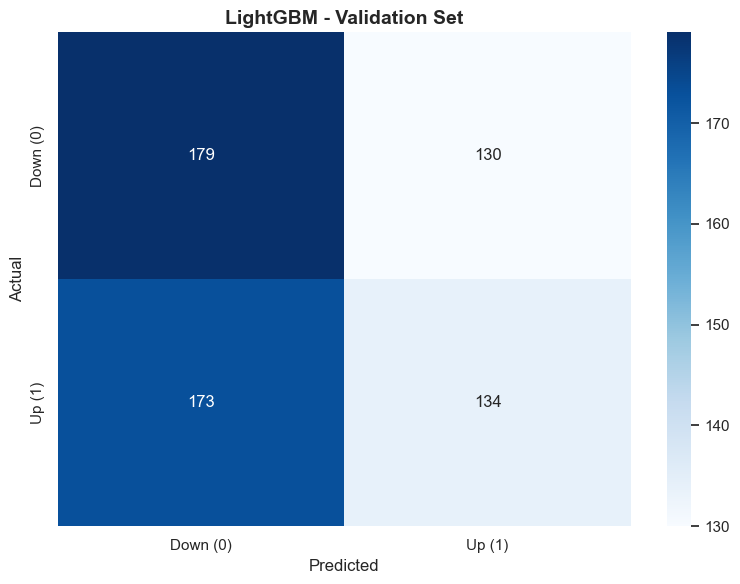

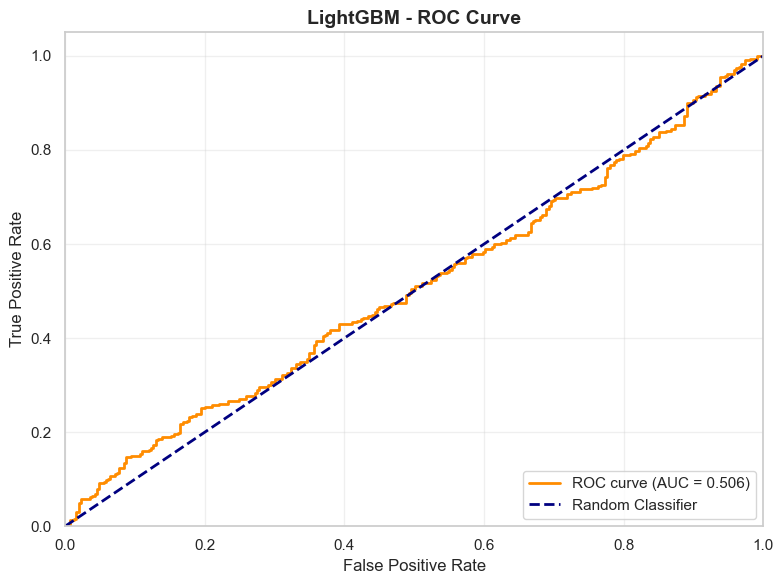

In [19]:
plot_confusion_matrix(y_val, val_pred, title="LightGBM - Validation Set")
plot_roc_curve(y_val, val_pred_proba, title="LightGBM - ROC Curve")

### 4. Comparison of Machine Learning Models and Baselines

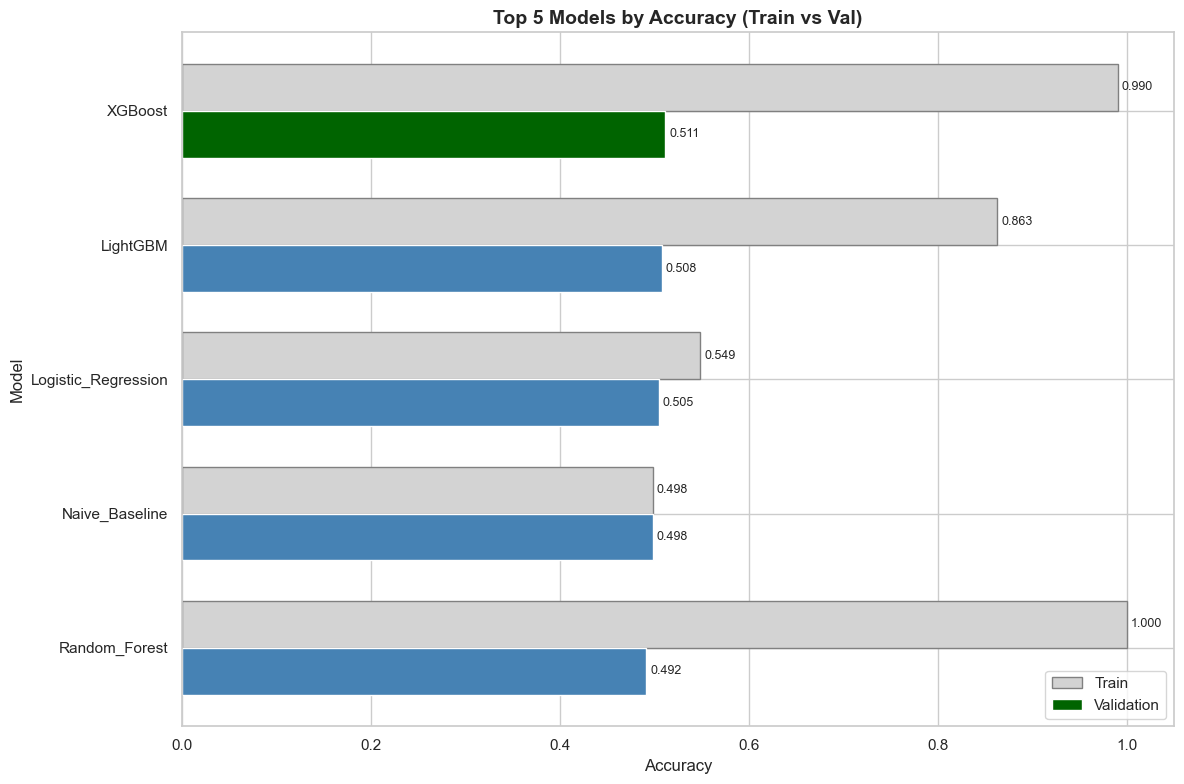


Top 5 Models by Accuracy (Sorted by Validation Performance)
Rank  Model Name                          Train Accuracy  Val Accuracy    Delta     
-------------------------------------------------------------------------------------
1     XGBoost                             0.9903          0.5114          0.4789    
2     LightGBM                            0.8629          0.5081          0.3548    
3     Logistic_Regression                 0.5487          0.5049          0.0438    
4     Naive_Baseline                      0.4984          0.4984          0.0000    
5     Random_Forest                       1.0000          0.4919          0.5081    



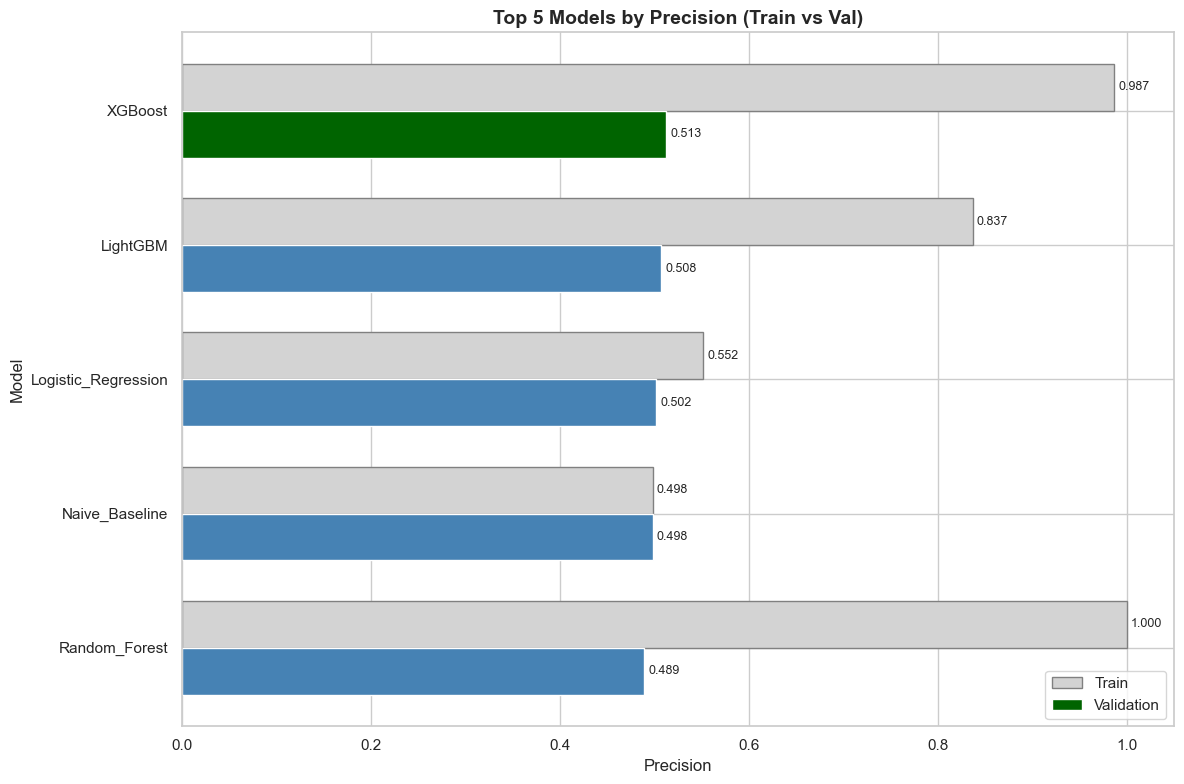


Top 5 Models by Precision (Sorted by Validation Performance)
Rank  Model Name                          Train Precision Val Precision   Delta     
-------------------------------------------------------------------------------------
1     XGBoost                             0.9865          0.5127          0.4738    
2     LightGBM                            0.8371          0.5076          0.3296    
3     Logistic_Regression                 0.5517          0.5024          0.0493    
4     Naive_Baseline                      0.4984          0.4984          0.0000    
5     Random_Forest                       1.0000          0.4894          0.5106    



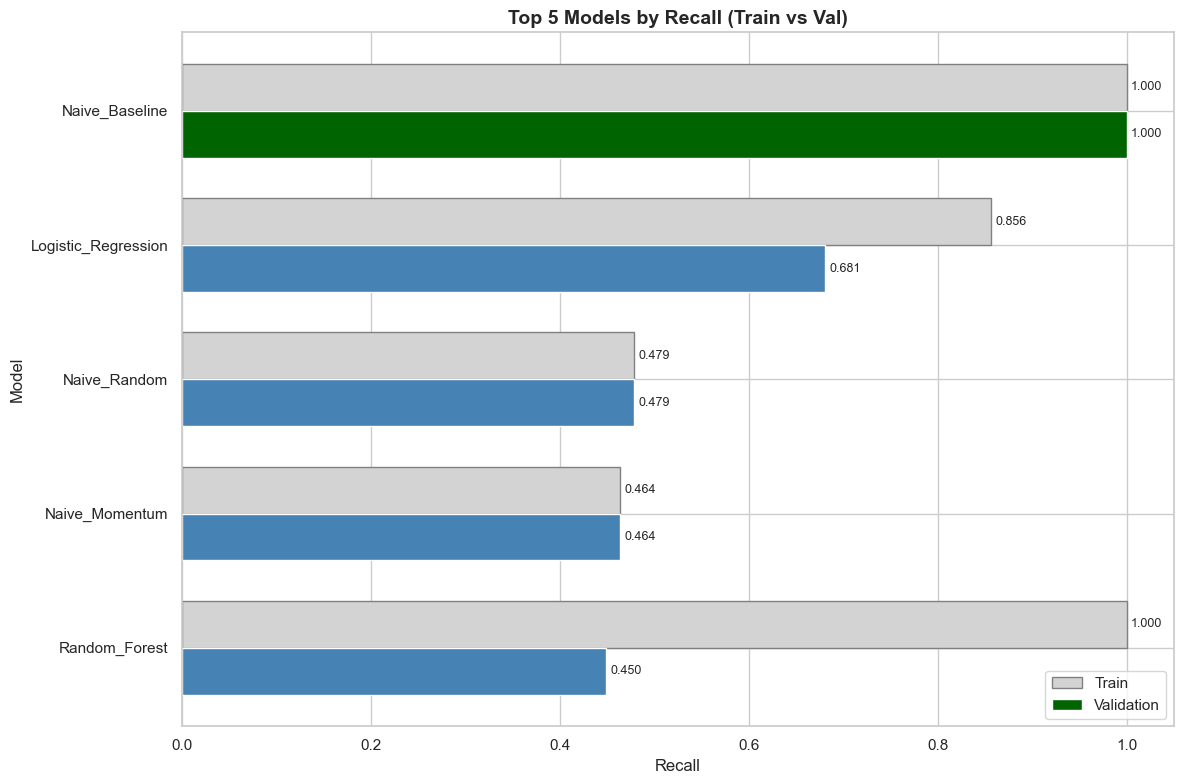


Top 5 Models by Recall (Sorted by Validation Performance)
Rank  Model Name                          Train Recall    Val Recall      Delta     
-------------------------------------------------------------------------------------
1     Naive_Baseline                      1.0000          1.0000          0.0000    
2     Logistic_Regression                 0.8563          0.6808          0.1755    
3     Naive_Random                        0.4788          0.4788          0.0000    
4     Naive_Momentum                      0.4641          0.4641          0.0000    
5     Random_Forest                       1.0000          0.4495          0.5505    



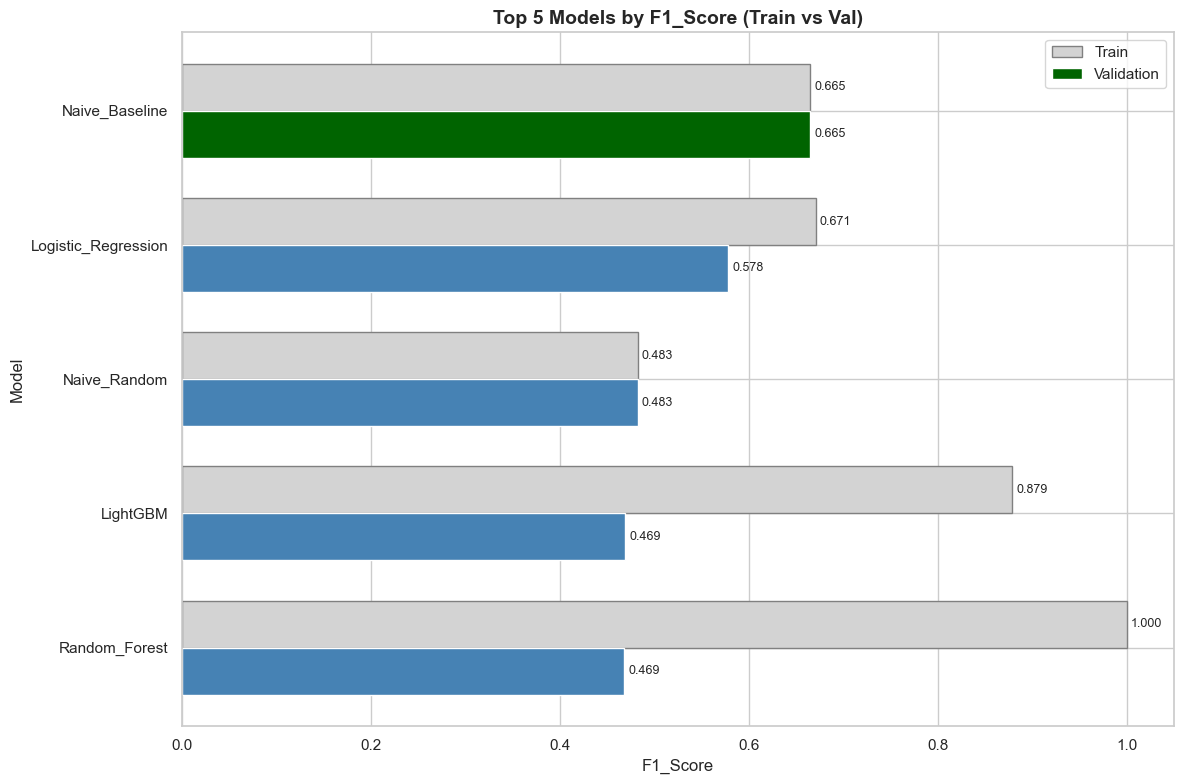


Top 5 Models by F1_Score (Sorted by Validation Performance)
Rank  Model Name                          Train F1_Score  Val F1_Score    Delta     
-------------------------------------------------------------------------------------
1     Naive_Baseline                      0.6652          0.6652          0.0000    
2     Logistic_Regression                 0.6711          0.5781          0.0929    
3     Naive_Random                        0.4828          0.4828          0.0000    
4     LightGBM                            0.8788          0.4694          0.4095    
5     Random_Forest                       1.0000          0.4686          0.5314    



In [20]:
for metric in ["Accuracy", "Precision", "Recall", "F1_Score"]:
    plot_top_classification_models(CLASSIFICATION_RESULTS, metric=metric, top_n=5)

### 5. Hyperparameter Tuning for Logistic Regression

Logistic Regression model performed best in terms of F1-Score out of machine learning models, so we will perform hyperparameter tuning on it.

In [21]:
# Feature Set Experiments

# Different feature sets to experiment with
FEATURE_SETS = {
    "Baseline": BASELINE_FEATURES,
    "Price_Only": [
        "Close",
        "Close_Lag1",
        "Close_Lag5",
        "Close_Lag7",
        "Close_Lag30",
    ],
    "Returns_Only": [
        "Return",
        "Log_Return",
        "Return_Lag1",
        "Return_Lag5",
        "Return_Lag7",
        "Return_Lag30",
    ],
    "Technical_Indicators": TECH_INDICATORS
    + [
        "Close",
        "Volume",
        "Return",
    ],
    "Lag_Features": LAG_FEATURES + ["Close", "Return"],
    "Momentum": MOMENTUM_FEATURES
    + [
        "Close",
        "Return",
        "Close_Lag7",
        "Return_Lag7",
    ],
    "Rolling_Stats": ROLLING_STATS
    + [
        "Close",
        "Return",
        "Return_Lag7",
        "Return_Lag30",
    ],
    "Temporal_Only": TEMPORAL_FEATURES
    + [
        "Close",
        "Return",
        "Close_Lag7",
        "Return_Lag7",
    ],
    "Price_Dynamics": PRICE_DYNAMICS + LAG_FEATURES,
    "Technical_Plus_Momentum": TECH_INDICATORS
    + MOMENTUM_FEATURES
    + [
        "Close",
        "Return",
        "Volume",
    ],
    "All_Features": ALL_FEATURES,
}

# Container for feature experiment results
FEATURE_EXPERIMENT_RESULTS = {}

print(f"\nTotal feature sets to evaluate: {len(FEATURE_SETS)}")
for name, features in FEATURE_SETS.items():
    print(f"  {name}: {len(features)} features")


Total feature sets to evaluate: 11
  Baseline: 11 features
  Price_Only: 5 features
  Returns_Only: 6 features
  Technical_Indicators: 5 features
  Lag_Features: 10 features
  Momentum: 7 features
  Rolling_Stats: 6 features
  Temporal_Only: 8 features
  Price_Dynamics: 17 features
  Technical_Plus_Momentum: 8 features
  All_Features: 28 features


In [22]:
print("=" * 60)
print("Evaluating Feature Sets with Logistic Regression")
print("=" * 60)

for feature_set_name, features in FEATURE_SETS.items():
    print(f"\nEvaluating: {feature_set_name} ({len(features)} features)")
    print("-" * 60)

    try:
        model, train_metrics, val_metrics, train_pred, val_pred, val_pred_proba = (
            evaluate_classifier_feature_set(
                model_name="logistic_regression",
                features=features,
                X_train=X_train,
                y_train=y_train,
                X_val=X_val,
                y_val=y_val,
                random_seed=RANDOM_SEED,
            )
        )

        # Store results
        FEATURE_EXPERIMENT_RESULTS[f"LR_{feature_set_name}"] = {
            "train_metrics": train_metrics,
            "val_metrics": val_metrics,
            "model": model,
            "features": features,
            "predictions": val_pred,
            "probabilities": val_pred_proba,
        }

        # Print metrics
        print(
            f"Training\nAcc: {train_metrics['Accuracy']:.4f}, "
            f"F1: {train_metrics['F1_Score']:.4f}, "
            f"Precision: {train_metrics['Precision']:.4f}, "
            f"Recall: {train_metrics['Recall']:.4f}"
        )

        print(
            f"Validation\nAcc: {val_metrics['Accuracy']:.4f}, "
            f"F1: {val_metrics['F1_Score']:.4f}, "
            f"Precision: {val_metrics['Precision']:.4f}, "
            f"Recall: {val_metrics['Recall']:.4f}"
        )

        if "ROC_AUC" in val_metrics:
            print(f"ROC-AUC: {val_metrics['ROC_AUC']:.4f}")

    except Exception as e:
        print(f"Error evaluating {feature_set_name}: {str(e)}")

print("\n" + "=" * 60)
print("Feature Set Evaluation Complete")
print("=" * 60)

Evaluating Feature Sets with Logistic Regression

Evaluating: Baseline (11 features)
------------------------------------------------------------
Training
Acc: 0.4864, F1: 0.4882, Precision: 0.5258, Recall: 0.4557
Validation
Acc: 0.4903, F1: 0.4530, Precision: 0.4869, Recall: 0.4235
ROC-AUC: 0.4859

Evaluating: Price_Only (5 features)
------------------------------------------------------------
Training
Acc: 0.5449, F1: 0.6804, Precision: 0.5465, Recall: 0.9010
Validation
Acc: 0.5146, F1: 0.6102, Precision: 0.5087, Recall: 0.7622
ROC-AUC: 0.5315

Evaluating: Returns_Only (6 features)
------------------------------------------------------------
Training
Acc: 0.5411, F1: 0.6950, Precision: 0.5406, Recall: 0.9728
Validation
Acc: 0.4951, F1: 0.6594, Precision: 0.4967, Recall: 0.9805
ROC-AUC: 0.5568

Evaluating: Technical_Indicators (5 features)
------------------------------------------------------------
Training
Acc: 0.5376, F1: 0.6993, Precision: 0.5376, Recall: 1.0000
Validation
Acc: 0.

/Users/klipiec/Desktop/Internship/projects/crypto_forecasting_project/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/klipiec/Desktop/Internship/projects/crypto_forecasting_project/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/klipiec/Desktop/Internship/projects/crypto_forecasting_project/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with 

In [23]:
# Compare all feature sets
print("\n" + "=" * 100)
print("Feature Set Performance Comparison")
print("=" * 100)
print(
    f"{'Feature Set':<30} {'# Features':<12} {'Val Acc':<12} {'Val Prec':<12} {'Val Rec':<12} {'Val F1':<12} {'Val AUC':<12}"
)
print("-" * 100)

feature_set_comparison = []
for name, results in FEATURE_EXPERIMENT_RESULTS.items():
    feature_set_name = name.replace("LR_", "")
    n_features = len(results["features"])
    val_acc = results["val_metrics"]["Accuracy"]
    val_prec = results["val_metrics"]["Precision"]
    val_rec = results["val_metrics"]["Recall"]
    val_f1 = results["val_metrics"]["F1_Score"]
    val_auc = results["val_metrics"].get("ROC_AUC", 0.0)

    feature_set_comparison.append(
        {
            "name": feature_set_name,
            "n_features": n_features,
            "val_acc": val_acc,
            "val_prec": val_prec,
            "val_rec": val_rec,
            "val_f1": val_f1,
            "val_auc": val_auc,
        }
    )

    print(
        f"{feature_set_name:<30} {n_features:<12} {val_acc:<12.4f} {val_f1:<12.4f} {val_auc:<12.4f}"
    )

# Sort by F1 score
feature_set_comparison.sort(key=lambda x: x["val_f1"], reverse=True)

print("=" * 100)
print("\nTop 5 Feature Sets by F1-Score:")
print("-" * 100)
for i, fs in enumerate(feature_set_comparison[:5], 1):
    print(
        f"{i}. {fs['name']:<30} F1: {fs['val_f1']:.4f}, "
        f"Accuracy: {fs['val_acc']:.4f}, "
        f"Precision: {fs['val_prec']:.4f}, "
        f"Recall: {fs['val_rec']:.4f}, "
        f"Features: {fs['n_features']}"
    )
print("=" * 100)


Feature Set Performance Comparison
Feature Set                    # Features   Val Acc      Val Prec     Val Rec      Val F1       Val AUC     
----------------------------------------------------------------------------------------------------
Baseline                       11           0.4903       0.4530       0.4859      
Price_Only                     5            0.5146       0.6102       0.5315      
Returns_Only                   6            0.4951       0.6594       0.5568      
Technical_Indicators           5            0.4984       0.6652       0.5002      
Lag_Features                   10           0.5179       0.6138       0.5319      
Momentum                       7            0.4968       0.6005       0.4992      
Rolling_Stats                  6            0.4968       0.5899       0.5027      
Temporal_Only                  8            0.4984       0.5395       0.5082      
Price_Dynamics                 17           0.4854       0.4468       0.4855      
Technic

### 6. Deep Learning Models

#### 1. Data Preparation for Deep Learning

In [24]:
# Selected features for deep learning
DL_FEATURES = [
    "Close",
    "Return",
    "Log_Return",
    "Volume",
    "Close_Lag1",
    "Close_Lag5",
    "Close_Lag7",
    "Return_Lag1",
    "Return_Lag5",
    "Return_Lag7",
    "MACD",
    "RSI",
    "Rolling_Mean_Return_30",
    "Rolling_Std_Return_30",
]

print(f"Selected {len(DL_FEATURES)} features for deep learning models")

# Scale features for neural networks

scaler_dl = MinMaxScaler()
X_train_scaled_dl = scaler_dl.fit_transform(X_train[DL_FEATURES])
X_val_scaled_dl = scaler_dl.transform(X_val[DL_FEATURES])
X_test_scaled_dl = scaler_dl.transform(X_test[DL_FEATURES])

print(f"\nTraining set shape: {X_train_scaled_dl.shape}")
print(f"Validation set shape: {X_val_scaled_dl.shape}")
print(f"Test set shape: {X_test_scaled_dl.shape}")

Selected 14 features for deep learning models

Training set shape: (2874, 14)
Validation set shape: (616, 14)
Test set shape: (617, 14)


In [25]:
# Hyperparameters for deep learning
SEQUENCE_LENGTH = 30
BATCH_SIZE = 64
HIDDEN_SIZE = 64
NUM_LAYERS = 2
DROPOUT = 0.2
LEARNING_RATE = 0.001
EPOCHS = 100

print(f"\nDeep Learning Hyperparameters:")
print(f"  Sequence Length: {SEQUENCE_LENGTH}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Hidden Size: {HIDDEN_SIZE}")
print(f"  Number of Layers: {NUM_LAYERS}")
print(f"  Dropout: {DROPOUT}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Epochs: {EPOCHS}")


Deep Learning Hyperparameters:
  Sequence Length: 30
  Batch Size: 64
  Hidden Size: 64
  Number of Layers: 2
  Dropout: 0.2
  Learning Rate: 0.001
  Epochs: 100


In [26]:
# Create sequence datasets
train_dataset = SequenceDatasetClassifier(
    X_train_scaled_dl, y_train.values, sequence_length=SEQUENCE_LENGTH
)

val_dataset = SequenceDatasetClassifier(
    X_val_scaled_dl, y_val.values, sequence_length=SEQUENCE_LENGTH
)

test_dataset = SequenceDatasetClassifier(
    X_test_scaled_dl, y_test.values, sequence_length=SEQUENCE_LENGTH
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # Don't shuffle for time series
)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training sequences: {len(train_dataset)}")
print(f"Validation sequences: {len(val_dataset)}")
print(f"Test sequences: {len(test_dataset)}")
print(f"\nNumber of batches:")
print(f"  Train: {len(train_loader)}")
print(f"  Validation: {len(val_loader)}")
print(f"  Test: {len(test_loader)}")

Training sequences: 2844
Validation sequences: 586
Test sequences: 587

Number of batches:
  Train: 45
  Validation: 10
  Test: 10


#### 2. LSTM Classifier

In [27]:
# LSTM Classifier

print("\n" + "=" * 60)
print("Training LSTM Classifier")
print("=" * 60)

lstm_result = train_nn_classifier(
    model_name="LSTM",
    train_loader=train_loader,
    val_loader=val_loader,
    input_size=len(DL_FEATURES),
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    lr=LEARNING_RATE,
    epochs=EPOCHS,
    verbose=True,
    print_every=20,
)

lstm_model = lstm_result["model"]
lstm_history = lstm_result["history"]
device = lstm_result["device"]

print(f"\nBest epoch: {lstm_result['best_epoch']}")
print(f"Best validation loss: {lstm_result['best_val_loss']:.6f}")


Training LSTM Classifier
Using device: mps
Model parameters: 53,825

Starting training for 100 epochs...
Epoch 20/100
  Train Loss: 0.688076 | Val Loss: 0.695428
  Train Acc: 0.5401 | Val Acc: 0.4710
  Train Precision: 0.5443 | Val Precision: 0.4804
  Train Recall: 0.8922 | Val Recall: 0.7568
  Train F1: 0.6761 | Val F1: 0.5878
Epoch 40/100
  Train Loss: 0.685096 | Val Loss: 0.698843
  Train Acc: 0.5580 | Val Acc: 0.4744
  Train Precision: 0.5609 | Val Precision: 0.4612
  Train Recall: 0.8222 | Val Recall: 0.3253
  Train F1: 0.6668 | Val F1: 0.3815
Epoch 60/100
  Train Loss: 0.681926 | Val Loss: 0.698314
  Train Acc: 0.5534 | Val Acc: 0.4932
  Train Precision: 0.5666 | Val Precision: 0.4906
  Train Recall: 0.7229 | Val Recall: 0.4452
  Train F1: 0.6353 | Val F1: 0.4668
Epoch 80/100
  Train Loss: 0.668744 | Val Loss: 0.701908
  Train Acc: 0.5907 | Val Acc: 0.5137
  Train Precision: 0.5985 | Val Precision: 0.5096
  Train Recall: 0.7268 | Val Recall: 0.6370
  Train F1: 0.6564 | Val F1: 0

In [28]:
# Evaluate LSTM on training set
lstm_model.eval()
train_predictions_lstm = []
train_actuals_lstm = []
train_probabilities_lstm = []

with torch.no_grad():
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        pred = lstm_model(batch_X)

        train_probabilities_lstm.extend(pred.cpu().numpy())
        train_predictions_lstm.extend((pred.cpu().numpy() > 0.5).astype(int))
        train_actuals_lstm.extend(batch_y.numpy())

train_predictions_lstm = np.array(train_predictions_lstm)
train_probabilities_lstm = np.array(train_probabilities_lstm)
train_actuals_lstm = np.array(train_actuals_lstm)

lstm_train_metrics = calculate_classification_metrics(
    train_actuals_lstm, train_predictions_lstm, train_probabilities_lstm
)

print(f"{'=' * 60}")
print("LSTM Classifier - Training Metrics")
print(f"{'=' * 60}")
for metric, value in lstm_train_metrics.items():
    if metric not in ["confusion_matrix", "classification_report"]:
        print(f"  {metric}: {value:.4f}")

# Evaluate LSTM on validation set
lstm_model.eval()
val_predictions_lstm = []
val_actuals_lstm = []
val_probabilities_lstm = []

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X = batch_X.to(device)
        pred = lstm_model(batch_X)

        val_probabilities_lstm.extend(pred.cpu().numpy())
        val_predictions_lstm.extend((pred.cpu().numpy() > 0.5).astype(int))
        val_actuals_lstm.extend(batch_y.numpy())

val_predictions_lstm = np.array(val_predictions_lstm)
val_probabilities_lstm = np.array(val_probabilities_lstm)
val_actuals_lstm = np.array(val_actuals_lstm)

# Calculate metrics
lstm_val_metrics = calculate_classification_metrics(
    val_actuals_lstm, val_predictions_lstm, val_probabilities_lstm
)

print(f"{'=' * 60}")
print("LSTM Classifier - Validation Metrics")
print(f"{'=' * 60}")
for metric, value in lstm_val_metrics.items():
    if metric not in ["confusion_matrix", "classification_report"]:
        print(f"  {metric}: {value:.4f}")

# Store results
CLASSIFICATION_RESULTS["LSTM_Classifier"] = {
    "val_metrics": lstm_val_metrics,
    "train_metrics": lstm_train_metrics,
    "model": lstm_model,
    "features": DL_FEATURES,
    "predictions": val_predictions_lstm,
    "probabilities": val_probabilities_lstm,
    "history": lstm_history,
}

LSTM Classifier - Training Metrics
  Accuracy: 0.5914
  Precision: 0.5986
  Recall: 0.7301
  F1_Score: 0.6578
  ROC_AUC: 0.6294
LSTM Classifier - Validation Metrics
  Accuracy: 0.4863
  Precision: 0.4850
  Recall: 0.5000
  F1_Score: 0.4924
  ROC_AUC: 0.4986


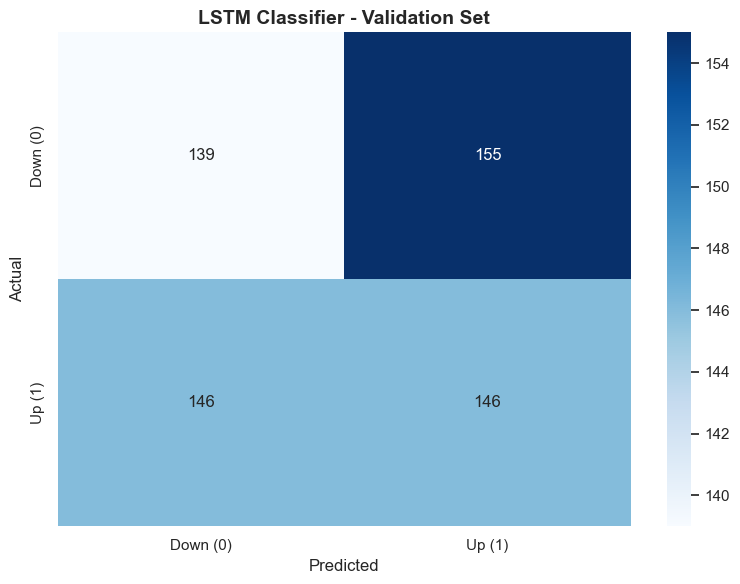

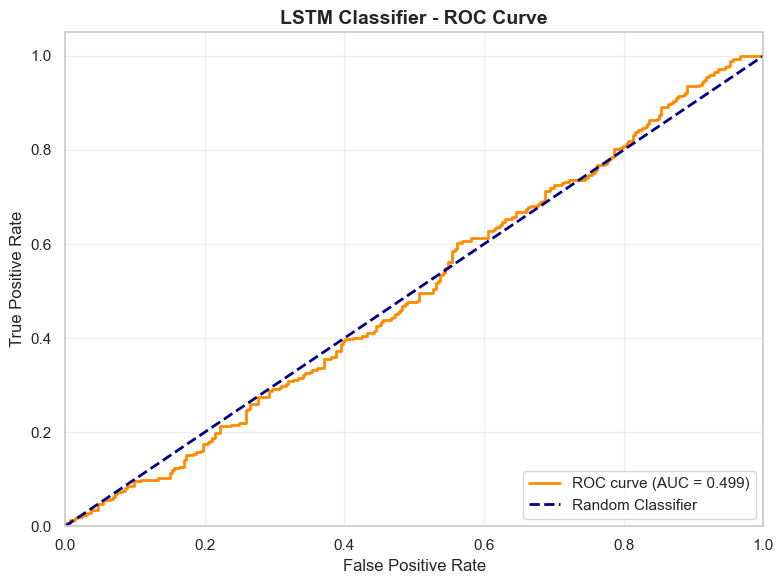

In [29]:
# Plot confusion matrix and ROC curve
plot_confusion_matrix(
    val_actuals_lstm, val_predictions_lstm, title="LSTM Classifier - Validation Set"
)

plot_roc_curve(
    val_actuals_lstm, val_probabilities_lstm, title="LSTM Classifier - ROC Curve"
)

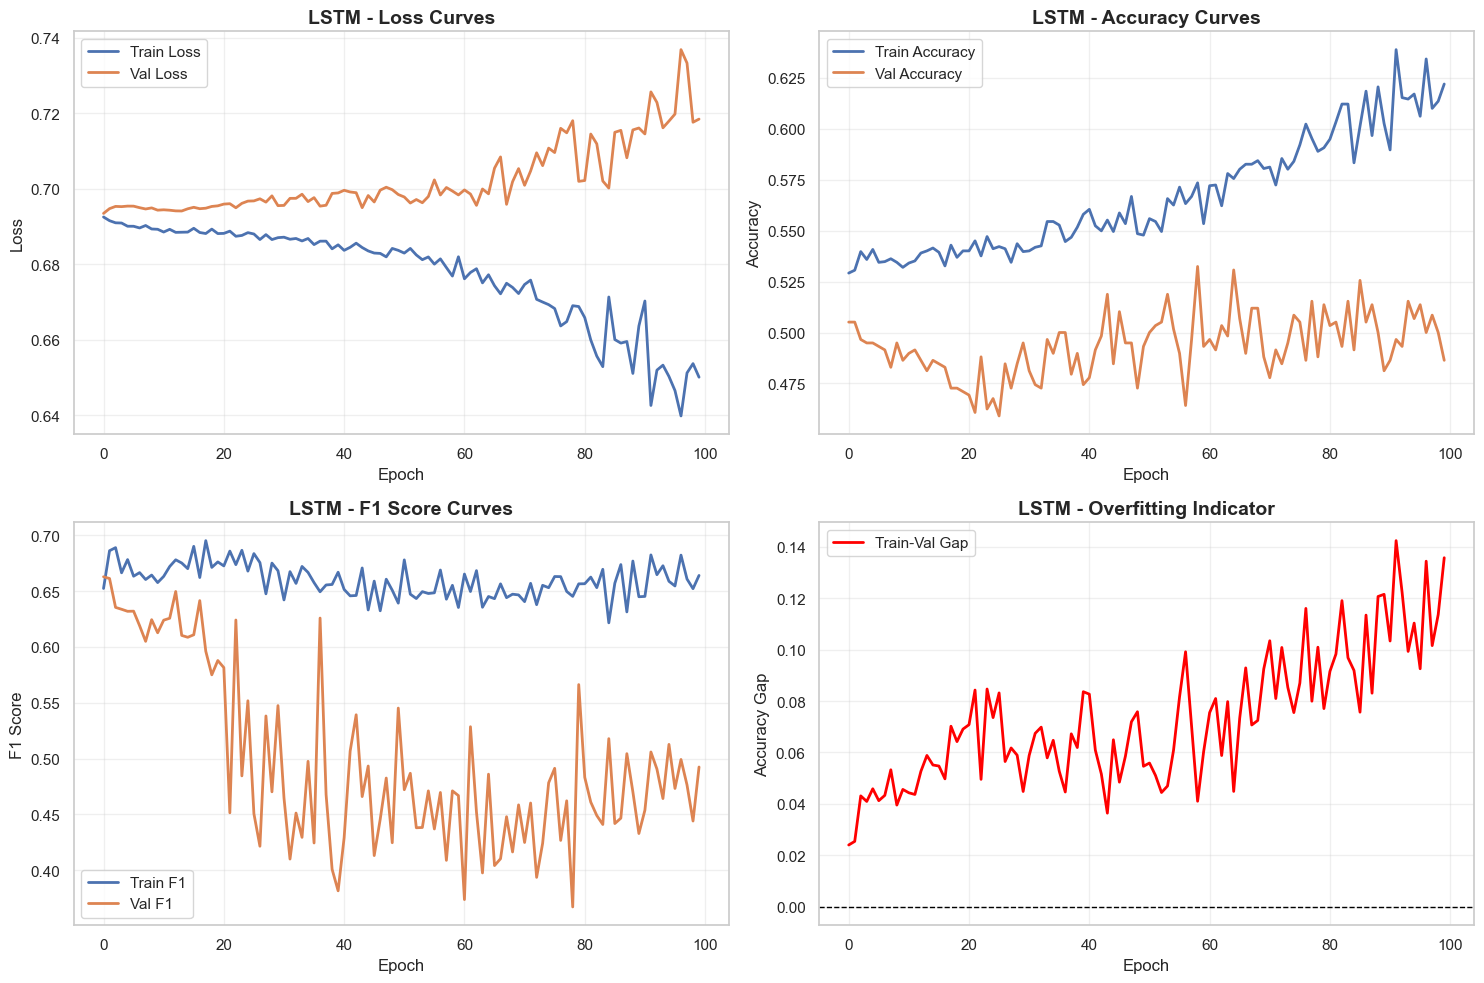

In [30]:
# Plot learning curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss curves
axes[0, 0].plot(lstm_history["train_loss"], label="Train Loss", linewidth=2)
axes[0, 0].plot(lstm_history["val_loss"], label="Val Loss", linewidth=2)
axes[0, 0].set_xlabel("Epoch", fontsize=12)
axes[0, 0].set_ylabel("Loss", fontsize=12)
axes[0, 0].set_title("LSTM - Loss Curves", fontsize=14, fontweight="bold")
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Accuracy curves
axes[0, 1].plot(lstm_history["train_accuracy"], label="Train Accuracy", linewidth=2)
axes[0, 1].plot(lstm_history["val_accuracy"], label="Val Accuracy", linewidth=2)
axes[0, 1].set_xlabel("Epoch", fontsize=12)
axes[0, 1].set_ylabel("Accuracy", fontsize=12)
axes[0, 1].set_title("LSTM - Accuracy Curves", fontsize=14, fontweight="bold")
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# F1 Score curves
axes[1, 0].plot(lstm_history["train_f1"], label="Train F1", linewidth=2)
axes[1, 0].plot(lstm_history["val_f1"], label="Val F1", linewidth=2)
axes[1, 0].set_xlabel("Epoch", fontsize=12)
axes[1, 0].set_ylabel("F1 Score", fontsize=12)
axes[1, 0].set_title("LSTM - F1 Score Curves", fontsize=14, fontweight="bold")
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Overfitting indicator
overfitting = np.array(lstm_history["train_accuracy"]) - np.array(
    lstm_history["val_accuracy"]
)
axes[1, 1].plot(overfitting, label="Train-Val Gap", linewidth=2, color="red")
axes[1, 1].axhline(y=0, color="black", linestyle="--", linewidth=1)
axes[1, 1].set_xlabel("Epoch", fontsize=12)
axes[1, 1].set_ylabel("Accuracy Gap", fontsize=12)
axes[1, 1].set_title("LSTM - Overfitting Indicator", fontsize=14, fontweight="bold")
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

#### 3. GRU Classifier

In [31]:
# GRU Classifier

print("\n" + "=" * 60)
print("Training GRU Classifier")
print("=" * 60)

gru_result = train_nn_classifier(
    model_name="GRU",
    train_loader=train_loader,
    val_loader=val_loader,
    input_size=len(DL_FEATURES),
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    lr=LEARNING_RATE,
    epochs=EPOCHS,
    verbose=True,
    print_every=20,
)

gru_model = gru_result["model"]
gru_history = gru_result["history"]

print(f"\nBest epoch: {gru_result['best_epoch']}")
print(f"Best validation loss: {gru_result['best_val_loss']:.6f}")


Training GRU Classifier
Using device: mps
Model parameters: 40,385

Starting training for 100 epochs...
Epoch 20/100
  Train Loss: 0.688342 | Val Loss: 0.695804
  Train Acc: 0.5274 | Val Acc: 0.5000
  Train Precision: 0.5384 | Val Precision: 0.4990
  Train Recall: 0.8529 | Val Recall: 0.8767
  Train F1: 0.6601 | Val F1: 0.6360
Epoch 40/100
  Train Loss: 0.687067 | Val Loss: 0.696662
  Train Acc: 0.5432 | Val Acc: 0.4642
  Train Precision: 0.5483 | Val Precision: 0.4671
  Train Recall: 0.8569 | Val Recall: 0.5342
  Train F1: 0.6687 | Val F1: 0.4984
Epoch 60/100
  Train Loss: 0.684263 | Val Loss: 0.699564
  Train Acc: 0.5541 | Val Acc: 0.4863
  Train Precision: 0.5555 | Val Precision: 0.4858
  Train Recall: 0.8569 | Val Recall: 0.5274
  Train F1: 0.6740 | Val F1: 0.5057
Epoch 80/100
  Train Loss: 0.675829 | Val Loss: 0.714898
  Train Acc: 0.5658 | Val Acc: 0.5051
  Train Precision: 0.5716 | Val Precision: 0.5028
  Train Recall: 0.7699 | Val Recall: 0.6199
  Train F1: 0.6561 | Val F1: 0.

In [32]:
# Evaluate GRU on training set
gru_model.eval()
train_predictions_gru = []
train_actuals_gru = []
train_probabilities_gru = []

with torch.no_grad():
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        pred = gru_model(batch_X)

        train_probabilities_gru.extend(pred.cpu().numpy())
        train_predictions_gru.extend((pred.cpu().numpy() > 0.5).astype(int))
        train_actuals_gru.extend(batch_y.numpy())

train_predictions_gru = np.array(train_predictions_gru)
train_probabilities_gru = np.array(train_probabilities_gru)
train_actuals_gru = np.array(train_actuals_gru)

gru_train_metrics = calculate_classification_metrics(
    train_actuals_gru, train_predictions_gru, train_probabilities_gru
)

print(f"{'=' * 60}")
print("GRU Classifier - Training Metrics")
print(f"{'=' * 60}")
for metric, value in gru_train_metrics.items():
    if metric not in ["confusion_matrix", "classification_report"]:
        print(f"  {metric}: {value:.4f}")

# Evaluate GRU on validation set
gru_model.eval()
val_predictions_gru = []
val_actuals_gru = []
val_probabilities_gru = []

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X = batch_X.to(device)
        pred = gru_model(batch_X)

        val_probabilities_gru.extend(pred.cpu().numpy())
        val_predictions_gru.extend((pred.cpu().numpy() > 0.5).astype(int))
        val_actuals_gru.extend(batch_y.numpy())

val_predictions_gru = np.array(val_predictions_gru)
val_probabilities_gru = np.array(val_probabilities_gru)
val_actuals_gru = np.array(val_actuals_gru)

# Calculate metrics
gru_val_metrics = calculate_classification_metrics(
    val_actuals_gru, val_predictions_gru, val_probabilities_gru
)

print(f"{'=' * 60}")
print("GRU Classifier - Validation Metrics")
print(f"{'=' * 60}")
for metric, value in gru_val_metrics.items():
    if metric not in ["confusion_matrix", "classification_report"]:
        print(f"  {metric}: {value:.4f}")

# Store results
CLASSIFICATION_RESULTS["GRU_Classifier"] = {
    "val_metrics": gru_val_metrics,
    "model": gru_model,
    "features": DL_FEATURES,
    "predictions": val_predictions_gru,
    "probabilities": val_probabilities_gru,
    "history": gru_history,
}

GRU Classifier - Training Metrics
  Accuracy: 0.5939
  Precision: 0.5938
  Recall: 0.7758
  F1_Score: 0.6727
  ROC_AUC: 0.6327
GRU Classifier - Validation Metrics
  Accuracy: 0.5256
  Precision: 0.5217
  Recall: 0.5753
  F1_Score: 0.5472
  ROC_AUC: 0.5189


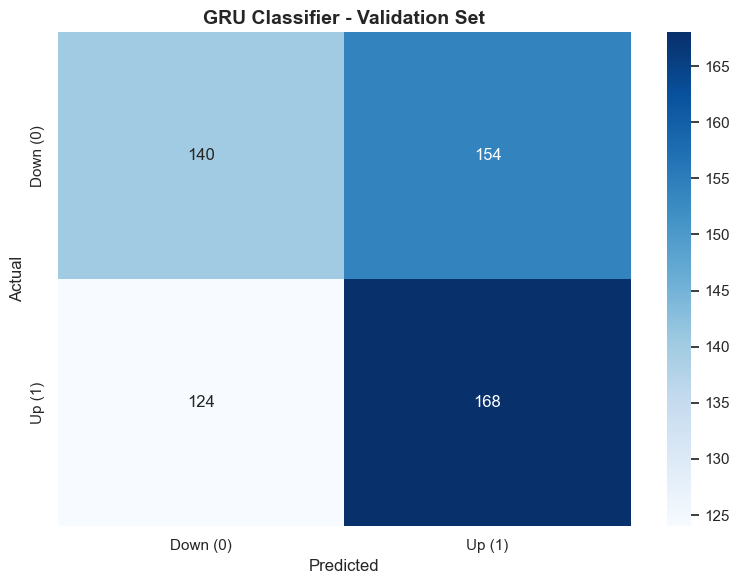

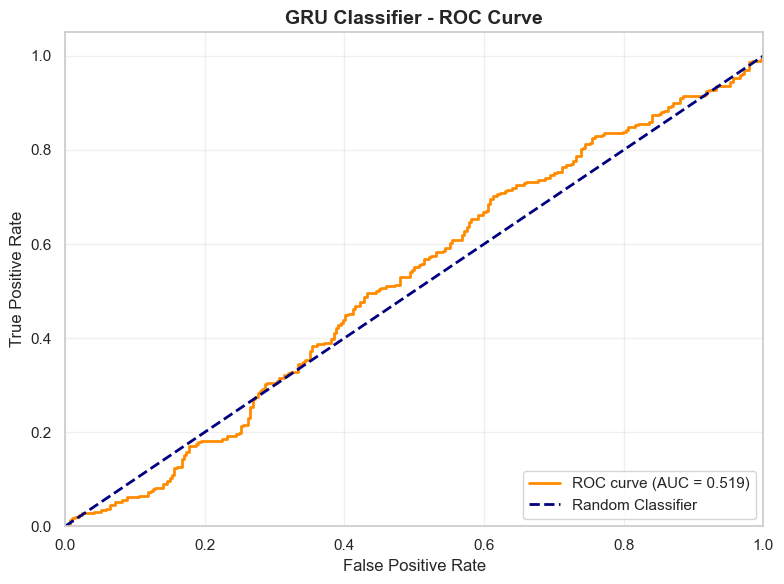

In [33]:
# Plot confusion matrix and ROC curve
plot_confusion_matrix(
    val_actuals_gru, val_predictions_gru, title="GRU Classifier - Validation Set"
)

plot_roc_curve(
    val_actuals_gru, val_probabilities_gru, title="GRU Classifier - ROC Curve"
)

### 7. Comparison of all Models

In [34]:
ALL_MODEL_RESULTS = {**CLASSIFICATION_RESULTS, **FEATURE_EXPERIMENT_RESULTS}

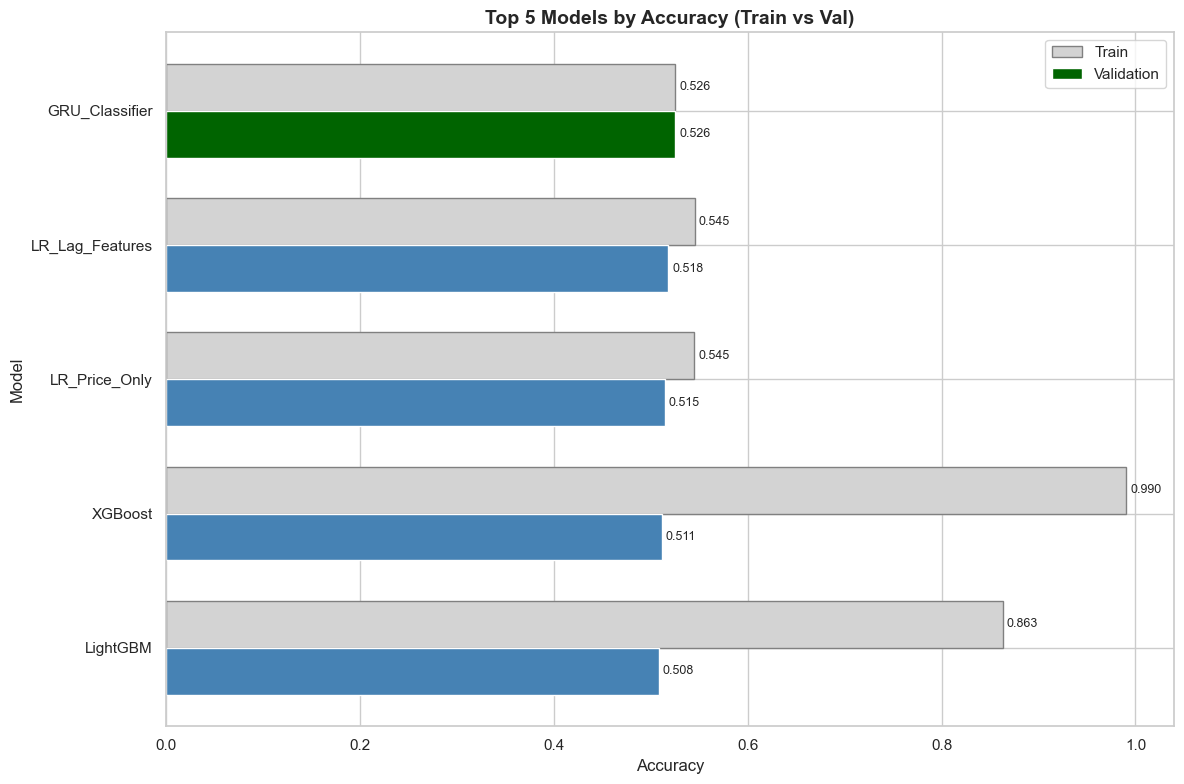


Top 5 Models by Accuracy (Sorted by Validation Performance)
Rank  Model Name                          Train Accuracy  Val Accuracy    Delta     
-------------------------------------------------------------------------------------
1     GRU_Classifier                      0.5256          0.5256          0.0000    
2     LR_Lag_Features                     0.5452          0.5179          0.0274    
3     LR_Price_Only                       0.5449          0.5146          0.0303    
4     XGBoost                             0.9903          0.5114          0.4789    
5     LightGBM                            0.8629          0.5081          0.3548    



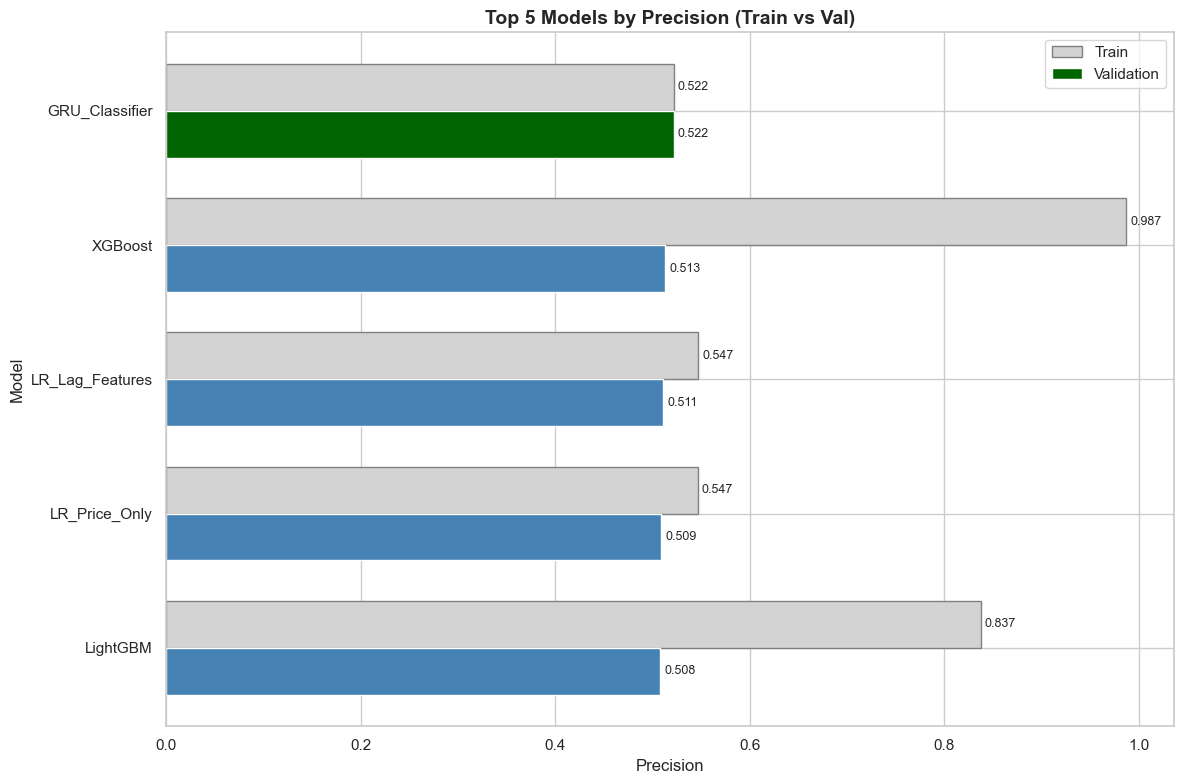


Top 5 Models by Precision (Sorted by Validation Performance)
Rank  Model Name                          Train Precision Val Precision   Delta     
-------------------------------------------------------------------------------------
1     GRU_Classifier                      0.5217          0.5217          0.0000    
2     XGBoost                             0.9865          0.5127          0.4738    
3     LR_Lag_Features                     0.5467          0.5108          0.0359    
4     LR_Price_Only                       0.5465          0.5087          0.0378    
5     LightGBM                            0.8371          0.5076          0.3296    



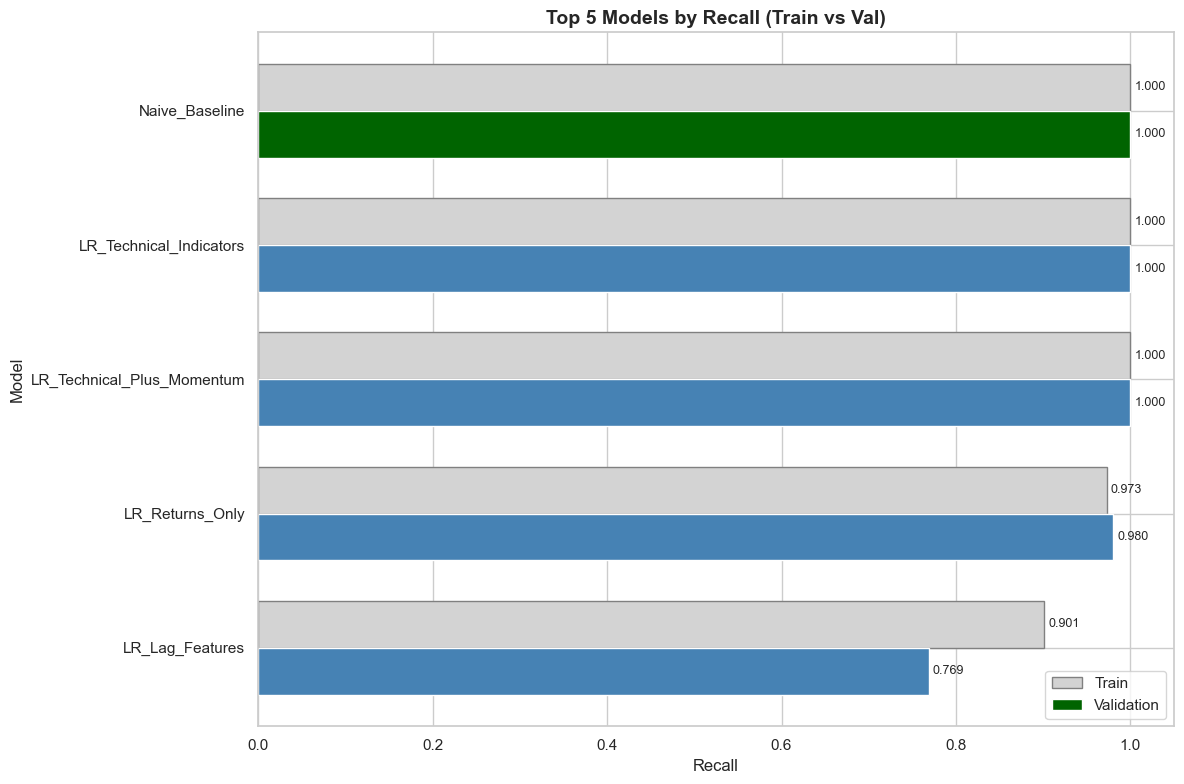


Top 5 Models by Recall (Sorted by Validation Performance)
Rank  Model Name                          Train Recall    Val Recall      Delta     
-------------------------------------------------------------------------------------
1     Naive_Baseline                      1.0000          1.0000          0.0000    
2     LR_Technical_Indicators             1.0000          1.0000          0.0000    
3     LR_Technical_Plus_Momentum          1.0000          1.0000          0.0000    
4     LR_Returns_Only                     0.9728          0.9805          -0.0076   
5     LR_Lag_Features                     0.9010          0.7687          0.1322    



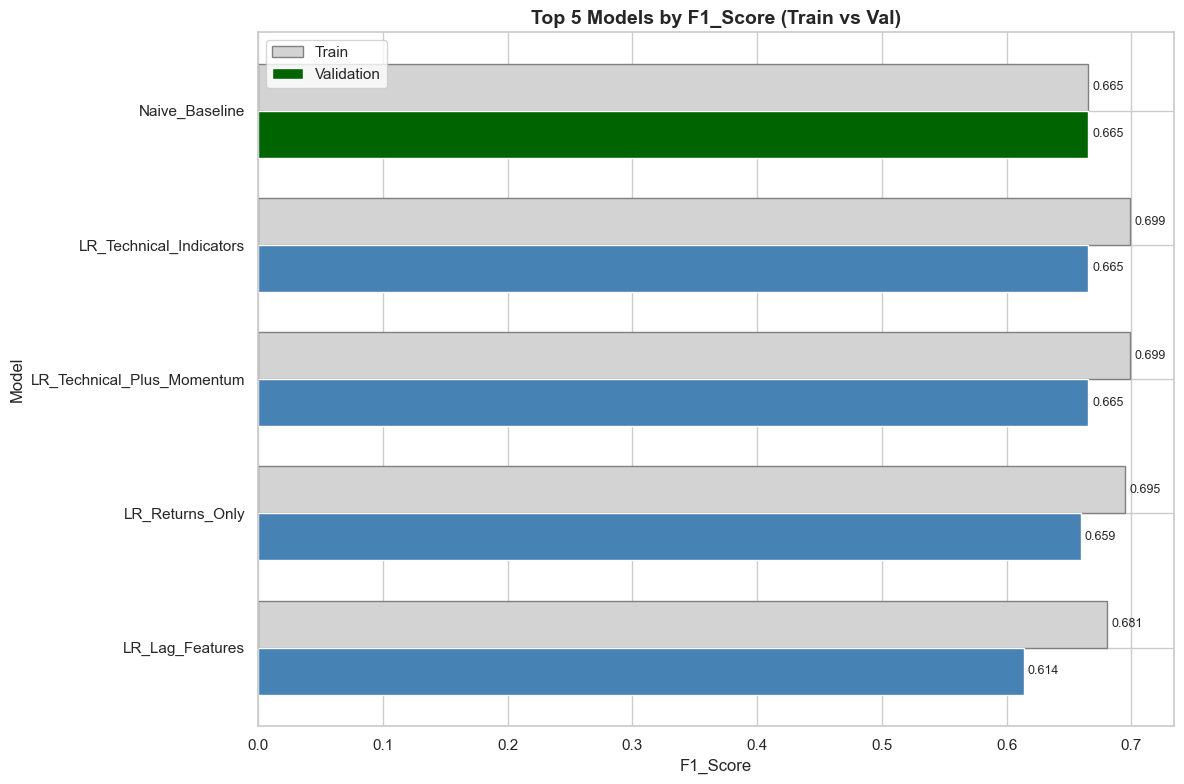


Top 5 Models by F1_Score (Sorted by Validation Performance)
Rank  Model Name                          Train F1_Score  Val F1_Score    Delta     
-------------------------------------------------------------------------------------
1     Naive_Baseline                      0.6652          0.6652          0.0000    
2     LR_Technical_Indicators             0.6993          0.6652          0.0340    
3     LR_Technical_Plus_Momentum          0.6993          0.6652          0.0340    
4     LR_Returns_Only                     0.6950          0.6594          0.0357    
5     LR_Lag_Features                     0.6805          0.6138          0.0667    



In [35]:
# Visualize top models for each metric
for metric in ["Accuracy", "Precision", "Recall", "F1_Score"]:
    plot_top_classification_models(ALL_MODEL_RESULTS, metric=metric, top_n=5)

In [36]:
# Print comprehensive summary
print("\n" + "=" * 100)
print("Comprehensive Model Summary")
print("=" * 100)
print(
    f"{'Model':<40} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'ROC-AUC':<12}"
)
print("-" * 100)

for name, results in sorted(
    ALL_MODEL_RESULTS.items(),
    key=lambda x: x[1]["val_metrics"]["F1_Score"],
    reverse=True,
):
    metrics = results["val_metrics"]
    print(
        f"{name:<40} {metrics['Accuracy']:<12.4f} {metrics['Precision']:<12.4f} "
        f"{metrics['Recall']:<12.4f} {metrics['F1_Score']:<12.4f} "
        f"{metrics.get('ROC_AUC', 0.0):<12.4f}"
    )

print("=" * 100)


Comprehensive Model Summary
Model                                    Accuracy     Precision    Recall       F1-Score     ROC-AUC     
----------------------------------------------------------------------------------------------------
Naive_Baseline                           0.4984       0.4984       1.0000       0.6652       0.0000      
LR_Technical_Indicators                  0.4984       0.4984       1.0000       0.6652       0.5002      
LR_Technical_Plus_Momentum               0.4984       0.4984       1.0000       0.6652       0.5002      
LR_Returns_Only                          0.4951       0.4967       0.9805       0.6594       0.5568      
LR_Lag_Features                          0.5179       0.5108       0.7687       0.6138       0.5319      
LR_Price_Only                            0.5146       0.5087       0.7622       0.6102       0.5315      
LR_Momentum                              0.4968       0.4968       0.7590       0.6005       0.4992      
LR_Rolling_Stats      

## 2. Conclusions

Experimental results show that predicting Bitcoin price direction is an exceptionally difficult task, as none of the tested models - including **Logistic Regression, Random Forest, XGBoost, LightGBM, LSTM, and GRU** - were able to consistently outperform naive baselines. The high level of market noise and volatility suggests that historical price data alone lacks sufficient predictive power for reliable classification. Ultimately, this study confirms that Bitcoin's short-term movements closely resemble a random walk, making it challenging for even complex deep learning architectures to gain a statistically significant edge.